### Lab1

Імпорт бібліотек та демонстрація вигляду даних

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/cyber_salaries.csv')

print(f"Розмір датасету: {df.shape}")
print("\nПриклад даних:")
display(df.head())

Розмір датасету: (1349, 11)

Приклад даних:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,EN,FT,Information Security Officer,68000,EUR,72762,DE,100,DE,S
1,2022,SE,FT,Security Officer,123400,USD,123400,US,0,US,M
2,2022,SE,FT,Security Officer,88100,USD,88100,US,0,US,M
3,2022,SE,FT,Security Engineer,163575,USD,163575,US,100,US,M
4,2022,SE,FT,Security Engineer,115800,USD,115800,US,100,US,M


Опрацювання пропусків та дублікатів

In [2]:
df.dropna()

if df.duplicated().sum() > 0:
    df.drop_duplicates()

print(f"Розмір датасету після обробки: {df.shape}")

Розмір датасету після обробки: (1349, 11)


Візуалізація даних

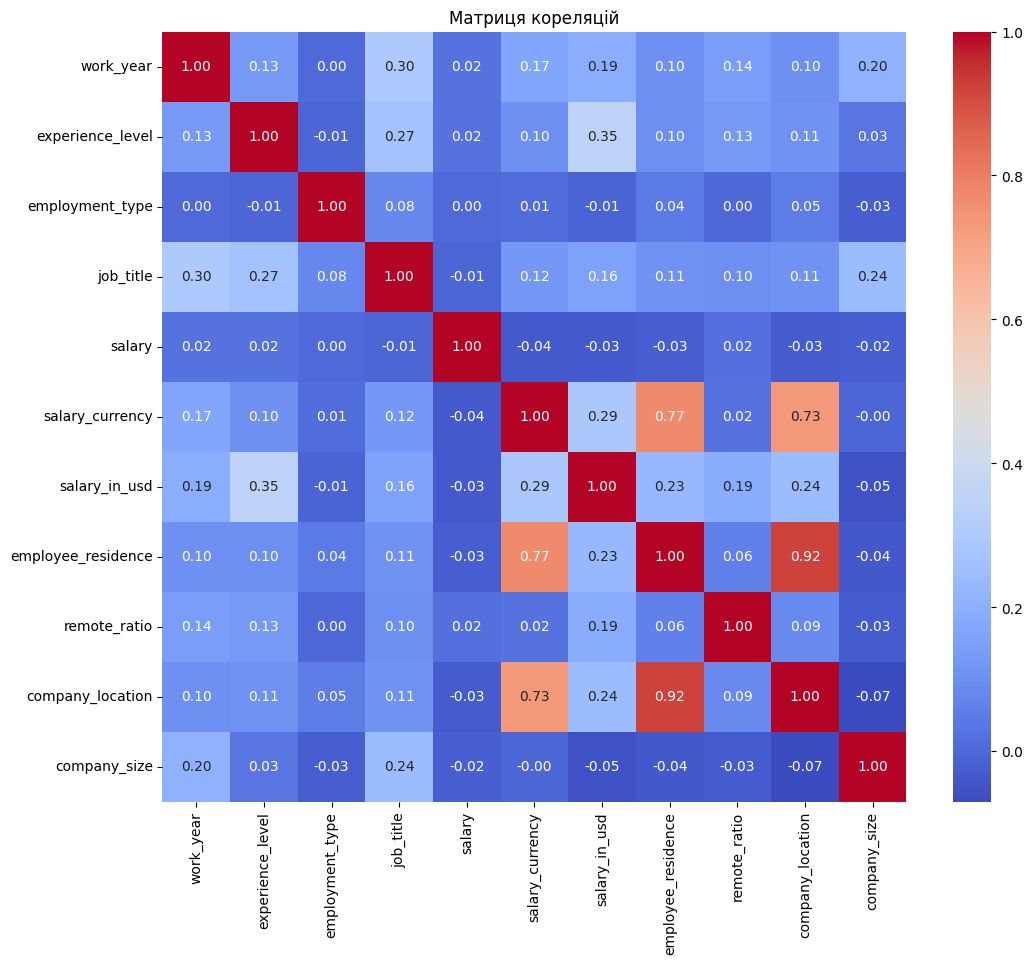

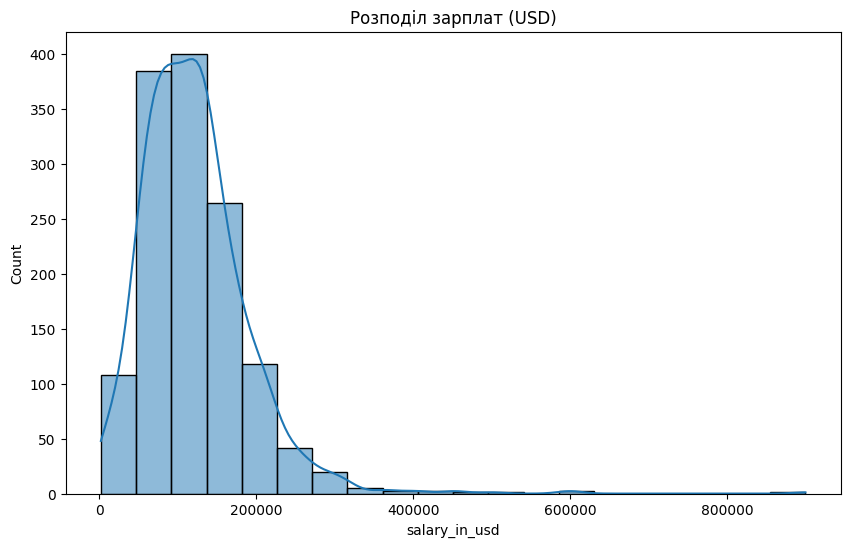

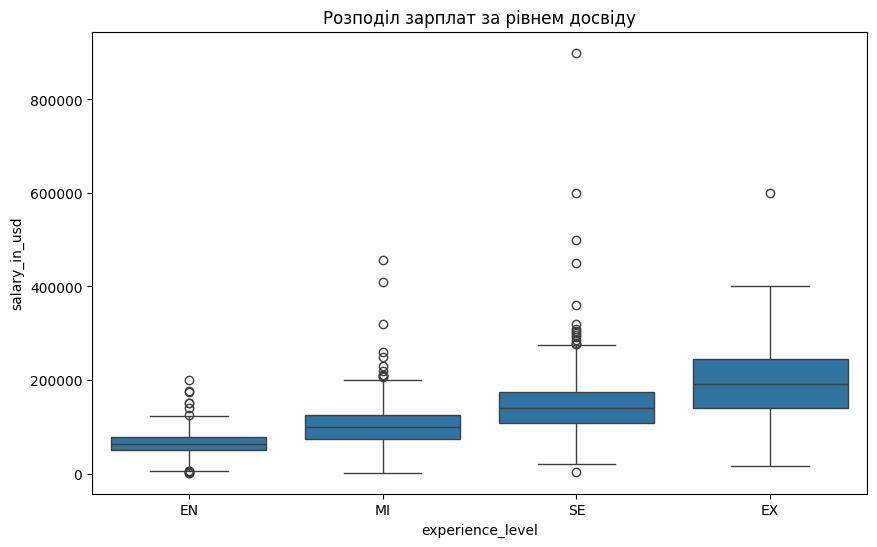

In [3]:
df_viz = df.copy()
le = LabelEncoder()

for col in df_viz.select_dtypes(include='object').columns:
    df_viz[col] = le.fit_transform(df_viz[col])

plt.figure(figsize=(12, 10))
sns.heatmap(df_viz.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матриця кореляцій")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], kde=True, bins=20)
plt.title("Розподіл зарплат (USD)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'])
plt.title("Розподіл зарплат за рівнем досвіду")
plt.show()

Нормалізація даних та підготовка до навчання

In [4]:
X = df.drop(['experience_level', 'salary', 'salary_currency', 'work_year'], axis=1)
y = df['experience_level']

size_mapping = {'S': 0, 'M': 1, 'L': 2}
X['company_size'] = X['company_size'].map(size_mapping).fillna(1)
X = pd.get_dummies(X, columns=['employment_type', 'job_title', 'employee_residence', 'company_location'], drop_first=True)

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Навчання класифікаторів

In [5]:
models = {}

#kNN
best_k = 1
best_score = 0
for k in range(1, 15):
    if k > len(X_train): break
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    if score >= best_score:
        best_score = score
        best_k = k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
models['kNN'] = knn_best
print(f"kNN (k={best_k}) Score: {best_score:.2f}")

#Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
models['DecisionTree'] = dt
print(f"Decision Tree Score: {dt.score(X_test_scaled, y_test):.2f}")

#SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(SVC(), param_grid, cv=2)
grid.fit(X_train_scaled, y_train)
models['SVM'] = grid.best_estimator_
print(f"SVM Score: {grid.best_estimator_.score(X_test_scaled, y_test):.2f}")

#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
models['RandomForest'] = rf
print(f"Random Forest Score: {rf.score(X_test_scaled, y_test):.2f}")

#AdaBoost
ada = AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME')
ada.fit(X_train_scaled, y_train)
models['AdaBoost'] = ada
print(f"AdaBoost Score: {ada.score(X_test_scaled, y_test):.2f}")


kNN (k=1) Score: 0.58
Decision Tree Score: 0.57
SVM Score: 0.61
Random Forest Score: 0.60
AdaBoost Score: 0.57


Вибір найкращої моделі

Найкраща модель: SVM
              precision    recall  f1-score   support

          EN       0.62      0.65      0.63        65
          EX       0.62      0.43      0.51        23
          MI       0.48      0.48      0.48       130
          SE       0.69      0.71      0.70       187

    accuracy                           0.61       405
   macro avg       0.60      0.57      0.58       405
weighted avg       0.61      0.61      0.61       405



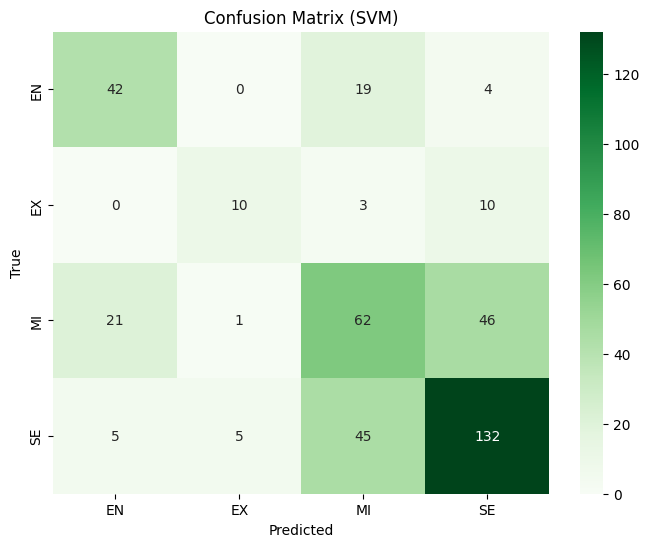

In [6]:
best_name = max(models, key=lambda x: models[x].score(X_test_scaled, y_test))
best_model = models[best_name]

print(f"Найкраща модель: {best_name}")

y_pred = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=le_target.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({best_name})')
plt.show()